
# ToDo



- SaveToFile plots
    - right path
    - save vibAvgs and/or other values as table in file

- loop through all audio files

    - check if note is really at given targetFrequency










In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from IPython.display import Audio
import librosa as lr
import math
from scipy import interpolate
import statsmodels.api as sm
from scipy.signal import find_peaks
from scipy.ndimage.filters import gaussian_filter
#from pathlib import Path
import os


def freqToCent(refFreq, freq):
    '''returns the Interval in cents'''
    return np.log2(np.array(freq)/refFreq)*1200

def centToFreq(refFreq, cent):
    '''returns a Frequency with the offset of cent relative to refFreq'''
    return refFreq*np.power(2,cent/1200)

def getFFTBinIndexByFreq(freq, sr, n_fft):
    '''retunrs index of FFT bin nearest to corresponding Frequency'''
    return round(freq/(sr/n_fft))

const_noteToFreqDict = {
    'ais': 'a#',
    'bis': 'b',
    'his': 'b#',
    'cis': 'c#',
    'dis': 'd#',
    'eis': 'e#',
    'fis': 'f#',
    'gis': 'g#',
    'aes': 'a♭',
    'bes': 'b𝄫',
    'hes': 'b♭',
    'ces': 'c♭',
    'des': 'd♭',
    'ees': 'e♭',
    'fes': 'f♭',
    'ges': 'g♭',
    'h': 'b',
    'b': 'b♭'
}
def noteToFreq(note):
    '''return the Frequency coresponding to the note(s) in german notation(cis4=c#4,b3=b♭3,a4=440Hz)'''
    if isinstance(note, str):
        s=note.lower()
        for key in const_noteToFreqDict.keys():
            if s[:len(key)]==key:
                s=s.replace(key,const_noteToFreqDict[key])
                break
        return lr.note_to_hz(s)
    else:
        output=[]
        for s in note:
            s=s.lower()
            for key in const_noteToFreqDict.keys():
                if s[:len(key)]==key:
                    s=s.replace(key,const_noteToFreqDict[key])
                    break
            output.append(lr.note_to_hz(s))
        return output
    


def chooseChannel(xAudio, targetFreq, targetFreqInterval=40, drawImages=True, drawOnlyLouderChannel=True, fft_param=65536):


    fft_win_length=fft_param//2
    
    lowerBound=centToFreq(targetFreq, -targetFreqInterval)
    higherBound=centToFreq(targetFreq, targetFreqInterval)

    lowerIndex=getFFTBinIndexByFreq(lowerBound,sr,fft_param)
    higherIndex=getFFTBinIndexByFreq(higherBound,sr,fft_param)
    
    magSum=np.zeros(2)
    stft=[[],[]]
    maxOverall=0
    for iChannel in range(0,2):

        stft[iChannel] = lr.stft(xAudio[iChannel],n_fft=fft_param,win_length=fft_win_length,hop_length=fft_win_length//16)
        fft_Data=np.transpose(np.abs(stft[iChannel]))
        

        
        for frame in fft_Data:
            maxOfFrame=max(frame[lowerIndex:higherIndex])
            magSum[iChannel]+=maxOfFrame
            if maxOverall<maxOfFrame:
                maxOverall=maxOfFrame
                
    louderChannel=np.argmax(magSum)

    if drawImages:    
        for iChannel in range(0,2):
            if drawOnlyLouderChannel and iChannel!=louderChannel:
                break
            
            plt.figure(figsize=(20, 10))
            plt.imshow(np.abs(stft[iChannel]), aspect='auto', origin='lower', extent=[0, np.shape(xAudio[iChannel])[0] / sr, 0, sr/2], vmax=maxOverall)
            plt.ylim(lowerBound,higherBound)
            plt.ylabel('Hz')
            plt.xlabel('seconds')
            plt.title(f'Channel: {iChannel}')
            plt.colorbar()
            plt.show()

    return louderChannel




def pitchDetection(audio, sampleRate, targetFreq, targetFreqInterval=None, \
                   maxInVoiceJumpInterval=None, acPitchInsensitivity=0.05, watchFrame=-1, acWindowLength=4096, acHopLength=None):
    '''
    finds Frequencies found in a given Interval by using autoCorrelation and their timeStamps
    returns: allNotesWeigthed: List of Frequencys
             timeScale: List of corresponding timeStamps
             outputDict: used for internal prossesing, contains all final used parameters and if there could no note be found

    Parameter:
        audio(ndarray): mono Audio(eg as returned by librosa.load)
        sampleRate(number): samples per second
        targetFreq(number): estimated Frequency
        targetFreqInterval(number): maximal offset to targetFreq in cents
        acPitchInsensitivity(number): minimal prominence for finding peaks in the autoCorrelation
        watchFrame(int): index of Frame for graph of autoCorrelation of this Frame. -1 means None
        acWindowLength(int): windowLength for autoCorrelation
        acHopLength(int): hopLength for autoCorrelation
        maxInVoiceJumpInterval(number): maximal jump in Frequency from one Frame to another in cents
                                        if None the smallest possible will be used(takes much more calculationTime)

    '''
    
    if acHopLength==None:
        acHopLength=acWindowLength//16
  
    outputDict = {
        'error':None,
        'sampleRate':sampleRate,
        'targetFreq':targetFreq,
        'targetFreqInterval':targetFreqInterval,
        'acPitchInsensitivity':acPitchInsensitivity,
        'watchFrame':watchFrame,
        'acWindowLength':acWindowLength,
        'acHopLength':acHopLength,
        'maxInVoiceJumpInterval':maxInVoiceJumpInterval    
        
    }  

    if maxInVoiceJumpInterval==None:
        maxTrys=15
        maxInVoiceJumpInterval=20
        lastMaxInVoiceJumpInterval=None
        highestFail=0
        for nTry in range(0,maxTrys):
            _,_,outDict = pitchDetection(audio, sampleRate, targetFreq, targetFreqInterval, \
                    maxInVoiceJumpInterval, acPitchInsensitivity, watchFrame, acWindowLength, acHopLength)
            if outDict['error']==None:
                lastMaxInVoiceJumpInterval=maxInVoiceJumpInterval
                maxInVoiceJumpInterval=(maxInVoiceJumpInterval+highestFail)/2
                if highestFail*1.05>lastMaxInVoiceJumpInterval:
                    break
            elif outDict['error']==f'no note in SearchInterval':
                if lastMaxInVoiceJumpInterval==None:
                    outputDict['error']=f'no note in SearchInterval'
                    print('no note in SearchInterval, maybe check targetFreq and targetFreqInterval')
                    break
                else:
                    highestFail=maxInVoiceJumpInterval
                    maxInVoiceJumpInterval=lastMaxInVoiceJumpInterval

            else:
                outputDict['error']=f'no freq in autoCor found'
                break
                
            #print(f'{nTry}: maxInVoiceJumpInterval: {maxInVoiceJumpInterval}')
                
        maxInVoiceJumpInterval=lastMaxInVoiceJumpInterval
        
        
    

    allNotesWeigthed=[]
    timeScale=[]
    breakWindowLoop=False
    for windowStart in range(0,len(audio)-acWindowLength,acHopLength):
        window=audio[windowStart:windowStart+acWindowLength]

        autoCor = sm.tsa.acf(window, nlags=acWindowLength)

        acPeaks, acPeaksProps = find_peaks(autoCor,prominence=acPitchInsensitivity)
        acPitches = sr/acPeaks
        if windowStart==acHopLength*watchFrame:
            print(acPitches)
        noteFound=False

        #single autoCorrelation plot for debugging
        if windowStart==acHopLength*watchFrame:

            print(acPeaksProps["right_bases"])
            nTicks=30
            freqScale = np.fromfunction(lambda i: sr/((i+1)*(len(autoCor)/nTicks)), (nTicks,))
            freqScale = np.round(freqScale,1)
            a = np.arange(np.shape(autoCor)[0])
            figFrame = plt.figure(3,figsize=(20,10))

            ax = figFrame.add_subplot()
            ax.plot(a, autoCor)
            ax.xaxis.set_ticks(np.arange(len(autoCor)/nTicks,len(autoCor)+1,len(autoCor)/nTicks))
            ax.xaxis.set_ticklabels(freqScale)

            ax.plot(a[acPeaks], autoCor[acPeaks],'x', markersize=18)


        if windowStart==0:
            if targetFreqInterval==None:
                tmpTargetFreqInterval=5
            else:
                tmpTargetFreqInterval=targetFreqInterval
        
        condition=True
        tryCount=0
        while condition:
            if windowStart==0:
                fMin=centToFreq(targetFreq,-tmpTargetFreqInterval)
                fMax=centToFreq(targetFreq,tmpTargetFreqInterval)


            if len(acPitches)>0:

                lastSubHarmIndex=int(fMax/acPitches[-1]+1)
                onlySubHarms=[]

                for peakIndex in range(0, len(acPitches)):
                    pitch = acPitches[peakIndex]
                    for iSubHarmonic in range(1,lastSubHarmIndex):
                        if pitch>fMin/iSubHarmonic and pitch<fMax/iSubHarmonic:
                            index=round(sr/pitch)
                            onlySubHarms.append([pitch,iSubHarmonic,peakIndex,index])
                            noteFound=True
                            if windowStart==acHopLength*watchFrame:
                                print(iSubHarmonic, pitch, pitch*iSubHarmonic, pitch - sr/(index+1))

                if noteFound:            
                    weigthsTotal=0
                    freqsTotal=0
                    for subHarm in onlySubHarms:
                        weigth=acPeaksProps["prominences"][subHarm[2]] #prominence of the peak as weight
                        weigthsTotal+=weigth
                        freqsTotal+=subHarm[0]*subHarm[1]*weigth

                    note=freqsTotal/weigthsTotal

                    allNotesWeigthed.append(note)
                    timeScale.append(windowStart/sr)

                    #
                    fMin=centToFreq(note,-maxInVoiceJumpInterval)
                    fMax=centToFreq(note,maxInVoiceJumpInterval)
                    condition=False
                #if no note found anymore, the note should have ended
                else:
                    if windowStart==0 and targetFreqInterval==None:
                        tmpTargetFreqInterval*=1.5
                        if tmpTargetFreqInterval>100:
                            print('targetFreqInterval>100 cent: maybe check targetFreq?')
                            break
                    else:
                        outputDict['error']=f'no note in SearchInterval'
                        breakWindowLoop=True
            else:
                outputDict['error']=f'no freq in autoCor found'
                breakWindowLoop=True
            
            if windowStart==0:
                condition= not noteFound

            else:
                condition=False
                
            if tryCount>20:
                condition=False
                print('tryCount>20 for tmpTargetFreqInterval')
            tryCount+=1
                
        if breakWindowLoop:
            break
            
    
    return allNotesWeigthed, timeScale, outputDict





  
def VibratoDetection(freqs, times=None, referencePitch=None, useVibratoOnlyforAmps=True, \
                     timeSensitiveAverages=True, maxVibratoFreq=15, minSmallPeaksFactor=0.30,\
                     minFactorAtimedProminece=0.75, minimaEdgesMinFactor=0.7, drawPlots=True):
    '''
    returns: 
        vibAmpsAvg : avarage Amplitude of Vibrato
        vibFreqAvg : avarage Frequency of Vibrato
        vibAmps : list of Amplitudes
        vibFreqs : list of Frequencys
        vibTimes : timestamps corresponding to vibAmps and vibFreqs
        extrema : List of all indices of the Vibrato Extrema
        startsWithMinima : True if first Extreme is a Minima

    
    Parameter:
        freqs : List of Frequency in which the Vibrato is to detect
        times : only needed for plot, timeStamps for freqs
        referencePitch=None : freqs are internally transformed to cent-Values, which needs a ReferencePitch. if None the average will be taken
        useVibratoOnlyforAmps=True : uses only Vibrato without slow pitch movement to calculate Amplitudes
        timeSensitiveAverages=True : calculates averages with wavelength as weigth(to counter higher Frequencys having more points and therefore more impact on average)
        maxVibratoFreq=15 : highest possible Frequency for the Vibrato to be expected
        minSmallPeaksFactor=0.30 : Factor 
        minFactorAtimedProminece=0.75
        minimaEdgesMinFactor=0.7
        drawPlots=True
    

    
    '''

    if referencePitch==None:
        referencePitch=np.mean(freqs)
    
    generalPitchesCent = freqToCent(referencePitch,gaussian_filter(freqs, 15))
    freqsCent = freqToCent(referencePitch,freqs)
    centDiff = freqsCent-generalPitchesCent
    smoothedCentDiff = gaussian_filter(centDiff, 3)

    minDistance = np.floor((len(centDiff)/audioDuration)/maxVibratoFreq)
    maximas,peakProps = find_peaks(smoothedCentDiff, prominence=0.1, width=3, distance=minDistance)




    #filter small maximas relative to surrounding maximas
    smallPeaks=[]

    if peakProps['prominences'][0]<peakProps['prominences'][1]*minSmallPeaksFactor \
    and peakProps['prominences'][0]<peakProps['prominences'][2]*minSmallPeaksFactor:
        smallPeaks.append(0)

    for i in range(1,len(maximas)-1):
        if peakProps['prominences'][i-1]*minSmallPeaksFactor>peakProps['prominences'][i] \
        and peakProps['prominences'][i]<peakProps['prominences'][i+1]*minSmallPeaksFactor:
            smallPeaks.append(i)

    if peakProps['prominences'][-1]<peakProps['prominences'][-2]*minSmallPeaksFactor \
    and peakProps['prominences'][-1]<peakProps['prominences'][-3]*minSmallPeaksFactor:
        smallPeaks.append(-1)

    #print(smallPeaks)

    mask = np.ones(len(maximas), dtype=bool)
    mask[smallPeaks] = False

    nPeaks = len(maximas)
    for key in peakProps:
        #print(key, len(peakProps[key]))
        if len(peakProps[key])==nPeaks:
            peakProps[key] = peakProps[key][mask]

    maximas = maximas[mask]


    #filter anormal timed maximas if not big enough
    timeBetweenPeaks=[]
    for i in range(0,len(maximas)-1):
        timeBetweenPeak = times[maximas[i+1]] - times[maximas[i]]
        timeBetweenPeaks.append(timeBetweenPeak)
        
    if len(timeBetweenPeaks)>4:
        Atimed=[]
        for i in range(0,len(timeBetweenPeaks)-1):

            if i==0:
                outl=timeBetweenPeaks[i+2]
                inl=timeBetweenPeaks[i]
                inr=timeBetweenPeaks[i]
                outr=timeBetweenPeaks[i+1]
            elif i==1:
                outl=timeBetweenPeaks[i+2]
                inl=timeBetweenPeaks[i-1]
                inr=timeBetweenPeaks[i]
                outr=timeBetweenPeaks[i+1]
            elif i==len(timeBetweenPeaks):
                outl=timeBetweenPeaks[i-2]
                inl=timeBetweenPeaks[i-1]
                inr=timeBetweenPeaks[i]
                outr=timeBetweenPeaks[i-3]
            else:
                outl=timeBetweenPeaks[i-2] # outer left
                inl=timeBetweenPeaks[i-1]
                inr=timeBetweenPeaks[i] # inner right
                outr=timeBetweenPeaks[i+1]

            seperatedRatio = np.mean([outl/inl,outl/inr,outr/inl,outr/inr])
            combinedRatio = np.mean([(inl+inr)/outl,(inl+inr)/outr])

            if seperatedRatio<1:
                seperatedRatio=1/seperatedRatio
            if combinedRatio<1:
                combinedRatio=1/combinedRatio 


            if combinedRatio<seperatedRatio \
            and peakProps['prominences'][i]<minFactorAtimedProminece:
                #print('atimes: ', i)
                Atimed.append(i)


        mask = np.ones(len(maximas), dtype=bool)
        mask[Atimed] = False

        nPeaks = len(maximas)
        for key in peakProps:
            if len(peakProps[key])==nPeaks:
                peakProps[key] = peakProps[key][mask]

        maximas = maximas[mask]


    #for minimas simply take lowest Value between two maximas
    minimas=[]
    

    for i in range(0,len(maximas)-1):

        minimaIndex=np.argmin(smoothedCentDiff[maximas[i]:maximas[i+1]])+maximas[i]

        if i==0: # for possible minima in front of first peak
            minimaIndexBefore = np.argmin(smoothedCentDiff[:maximas[i]])
            peakValue = smoothedCentDiff[maximas[i]]

            if peakValue-smoothedCentDiff[minimaIndexBefore] > (peakValue-smoothedCentDiff[minimaIndex])*minimaEdgesMinFactor:
                minimas.append(minimaIndexBefore)

        minimas.append(minimaIndex)


        if i==len(maximas)-2: # for possible minima behind last peak
            minimaIndexBehind=np.argmin(smoothedCentDiff[maximas[i+1]:])+maximas[i+1]
            peakValue = smoothedCentDiff[maximas[i]]

            if peakValue-smoothedCentDiff[minimaIndexBehind] > (peakValue-smoothedCentDiff[minimaIndex])*minimaEdgesMinFactor:
                minimas.append(minimaIndexBehind)

    if minimas[0]<maximas[0]:
        startsWithMinima=True
    else:
        startsWithMinima=False

        
    extrema = np.empty(len(maximas)+len(minimas), dtype=int)
    if startsWithMinima:
        extrema[0::2]=minimas
        extrema[1::2]=maximas
    else:
        extrema[0::2]=maximas
        extrema[1::2]=minimas
    
    
    #calc Amplitudes and VibratoFrequencys
    vibAmps=[]
    vibFreqs=[]
    vibTimes=[]
    weigths=[]

    for i in range(0,len(extrema)-1):

        timeStamp=(times[extrema[i+1]]+times[extrema[i]])/2
        vibTimes.append(timeStamp)

        if useVibratoOnlyforAmps:   
            a=smoothedCentDiff[extrema[i]]
            b=smoothedCentDiff[extrema[i+1]]

        else:
            a=freqToCent(targetFreq,freqs[extrema[i]])
            b=freqToCent(targetFreq,freqs[extrema[i+1]])

        amp=abs(a-b)
        vibAmps.append(amp)


        waveLength=amp=(times[extrema[i+1]]-times[extrema[i]])*2
        vibFreqs.append(1/waveLength)
        weigths.append(waveLength)


    if timeSensitiveAverages:
        vibAmpsAvg=np.average(vibAmps,weights=weigths)
        vibFreqAvg=np.average(vibFreqs,weights=weigths)
    else:
        vibAmpsAvg=np.average(vibAmps)
        vibFreqAvg=np.average(vibFreqs)
    
    
        
    if drawPlots:
        if times==None:
            print('Could not draw plot, parameter times not given')
        else:
            figPitch = plt.figure(figsize=(20,10))
            plt.title('VibratoOnlyCent')
            plt.plot(times, smoothedCentDiff)
            plt.plot(timesArr[maximas], smoothedCentDiff[maximas], 'x', markersize=18)
            plt.plot(timesArr[minimas], smoothedCentDiff[minimas], 'x', markersize=18)
        
        
        
    
        
        
        
        
    return vibAmps, vibFreqs, vibTimes, vibAmpsAvg, vibFreqAvg, extrema, startsWithMinima
    
    
    
    
    
const_tickSteps = [5,2.5,1]

def calcTickStepSize(valRange, minTicks=5, maxTicks=15):
    '''returns a tickStep so that valRange can be devided in at least minTicks and at most maxTicks'''
    
    if maxTicks/minTicks<2.5:
        print('minTicks and maxTicks to close, they need to have at least a factor of 2.5')
        return None
    
    stepIndex=2
    decimalFactor=1
    tickStep=const_tickSteps[stepIndex]
    while not minTicks<=valRange/tickStep<=maxTicks:
        if valRange/tickStep<minTicks:
            stepIndex+=1
            if stepIndex==len(const_tickSteps):
                decimalFactor/=10
                stepIndex=0
        if valRange/tickStep>maxTicks:
            stepIndex-=1
            if stepIndex==-1:
                decimalFactor*=10
                stepIndex=len(const_tickSteps)-1
                

        tickStep=const_tickSteps[stepIndex]*decimalFactor

    return tickStep


def drawPlot(x, y, figSize=None, style=None, vibAmpsAvg=None, vibFreqAvg=None):
    '''helpfunction for drawPlots()'''
    
    refFreq=targetFreq
    
    timeLabel = 'Time (s)'
    pitchHzLabel = 'Pitch (Hz)'
    pitchCentLabel = 'Pitch (Cent)'
    vibAmpLabel = 'Amplitude (cent)'
    vibFreqLabel = 'Frequency (Hz)'
    
    pitchTitle = 'Pitch'
    vibAmpTitle = 'Vibrato Amplitude'
    vibFreqTitle = 'Vibrato Frequency'
    combiTitle = 'Vibrato Analysis'
    
    pitchColor = '#1f77b4' # blue
    vibAmpColor = '#d62728' # red
    vibFreqColor = '#2ca02c' # green
    
    labelFontSize=14
    titleFontSize=16
    
    tickParams = dict(size=5, width=2, labelsize=12)
    
    combiAxesOffset=0.08
    combiPitchLineWidth=2
    combiVibAmpLineWidth=combiVibFreqLineWidth=1.1
    
    fig, host = plt.subplots(figsize=figSize)     
    host.set_xlabel(timeLabel, fontsize=labelFontSize) 
    
    if style=='pitch':
        
        par1 = host.twinx()
        p1 = host.plot(x,y, color=pitchColor)
        
        host.set_title(pitchTitle, fontsize=titleFontSize)
        host.set_ylabel(pitchHzLabel, fontsize=labelFontSize)
        par1.set_ylabel(pitchCentLabel, fontsize=labelFontSize)
        
        ylimCent=[freqToCent(refFreq,host.get_ylim()[0]),freqToCent(refFreq,host.get_ylim()[1])]
        ylimCentDiff=ylimCent[1]-ylimCent[0]

        tickStep = calcTickStepSize(ylimCentDiff)
        firstTickCent = tickStep * math.ceil(ylimCent[0] / tickStep)
        centTicks = np.arange(firstTickCent, ylimCent[1],tickStep)
        centTicksHz= centToFreq(refFreq,centTicks)

        par1.set_ylim(host.get_ylim())
        par1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(centTicksHz))

        if tickStep>=1:
            strCentTicks = [f'{t:.0f}' for t in centTicks]
        else:
            strCentTicks = centTicks

        par1.set_yticklabels(strCentTicks)
        
    elif style=='vibAmp':
        p1 = host.plot(x,y, color=vibAmpColor)
        
        host.set_title(vibAmpTitle, fontsize=titleFontSize)
        host.set_ylabel(vibAmpLabel, fontsize=labelFontSize)
        host.axhline(vibAmpsAvg, color=vibAmpColor)
    
    elif style=='vibFreq':
        p1 = host.plot(x,y, color=vibFreqColor)
        
        host.set_title(vibFreqTitle, fontsize=titleFontSize)
        host.set_ylabel(vibFreqLabel, fontsize=labelFontSize)
        host.axhline(vibFreqAvg, color=vibFreqColor)

    
    elif style=='combi':

        #pitch
        par1 = host.twinx()

        par1.spines.left.set_visible(True)
        #par1.spines.right.set_visible(False)
        par1.spines.left.set_position(("axes", -combiAxesOffset))
        par1.yaxis.set_label_position('left')
        par1.yaxis.set_ticks_position('left')
        
        p1 = host.plot(x[0],y[0], color=pitchColor, linewidth=combiPitchLineWidth)
        host.set_ylabel(pitchHzLabel, fontsize=labelFontSize)
        par1.set_ylabel(pitchCentLabel, fontsize=labelFontSize)
        
        ylimCent=[freqToCent(refFreq,host.get_ylim()[0]),freqToCent(refFreq,host.get_ylim()[1])]
        ylimCentDiff=ylimCent[1]-ylimCent[0]

        tickStep = calcTickStepSize(ylimCentDiff)
        firstTickCent = tickStep * math.ceil(ylimCent[0] / tickStep)
        centTicks = np.arange(firstTickCent, ylimCent[1],tickStep)
        centTicksHz= centToFreq(refFreq,centTicks)

        par1.set_ylim(host.get_ylim())
        par1.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(centTicksHz))

        if tickStep>=1:
            strCentTicks = [f'{t:.0f}' for t in centTicks]
        else:
            strCentTicks = centTicks

        par1.set_yticklabels(strCentTicks)
        
        
        host.tick_params(axis='y', colors=pitchColor, **tickParams)
        par1.tick_params(axis='y', colors=pitchColor, **tickParams)
        
        host.yaxis.label.set_color(pitchColor)
        par1.yaxis.label.set_color(pitchColor)
        
        
        #vibAmp
        par2 = host.twinx()
        
        p2 = par2.plot(x[1],y[1], color=vibAmpColor, linewidth=combiVibAmpLineWidth)
        par2.set_ylabel(vibAmpLabel, fontsize=labelFontSize)
        
        par2.tick_params(axis='y', colors=vibAmpColor, **tickParams)
        par2.yaxis.label.set_color(vibAmpColor)
        
        
        #vibFreq
        par3 = host.twinx()
        
        par3.spines.right.set_position(("axes", 1+combiAxesOffset))
        p3 = par3.plot(x[1],y[2], color=vibFreqColor, linewidth=combiVibFreqLineWidth)
        par3.set_ylabel(vibFreqLabel, fontsize=labelFontSize)
        
        par3.tick_params(axis='y', colors=vibFreqColor, **tickParams)
        par3.yaxis.label.set_color(vibFreqColor)
        
        
        #general
          
        par3.set_zorder(1)
        par3.patch.set_visible(True)
        par2.set_zorder(2)
        host.set_zorder(4)
        host.patch.set_visible(False)
        
        host.set_title(combiTitle, fontsize=titleFontSize)

        
    else:
        p1 = host.plot(x,y)
        print('unknown style:', style)
        

    plt.show()
    
    return fig


def drawPlots(freqs, times, vibAmps, vibFreqs, vibTimes, vibAmpsAvg=None, vibFreqAvg=None, figSize=(20,10), \
              combiPlot=True, pitchPlot=True, vibAmpPlot=True, vibFreqPlot=True):
    '''
    draws and returns different plots   
    
    '''
    
    figures=[[],[]]
    if combiPlot:
        figures[0].append(drawPlot([times,vibTimes], [freqs, vibAmps, vibFreqs], figSize, 'combi'))
        figures[1].append('combi')
        
    if pitchPlot:
        figures[0].append(drawPlot(times, freqs, figSize, 'pitch'))
        figures[1].append('pitch')
        
    if vibAmpPlot:
        figures[0].append(drawPlot(vibTimes, vibAmps, figSize, 'vibAmp', vibAmpsAvg=vibAmpsAvg))
        figures[1].append('vibAmp')
            
    if vibFreqPlot:
        figures[0].append(drawPlot(vibTimes, vibFreqs, figSize, 'vibFreq', vibFreqAvg=vibFreqAvg))
        figures[1].append('vibFreq')
            
    print(len(figures))        
    
    return figures


In [2]:
#Load AudioFile(s)

recordingFolder = '52+3 (Vl solo, h5)'
fileName = '1964_52+3.wav'
audioFile='Schnipsel\\'+recordingFolder+'\\'+fileName
audioDuration = None #None:whole File
xAudio, sr = lr.load(audioFile,mono=False,sr=None,offset=0,duration=audioDuration)

if audioDuration==None:
    audioDuration=len(xAudio[0])/sr
display(Audio(xAudio, rate=sr))

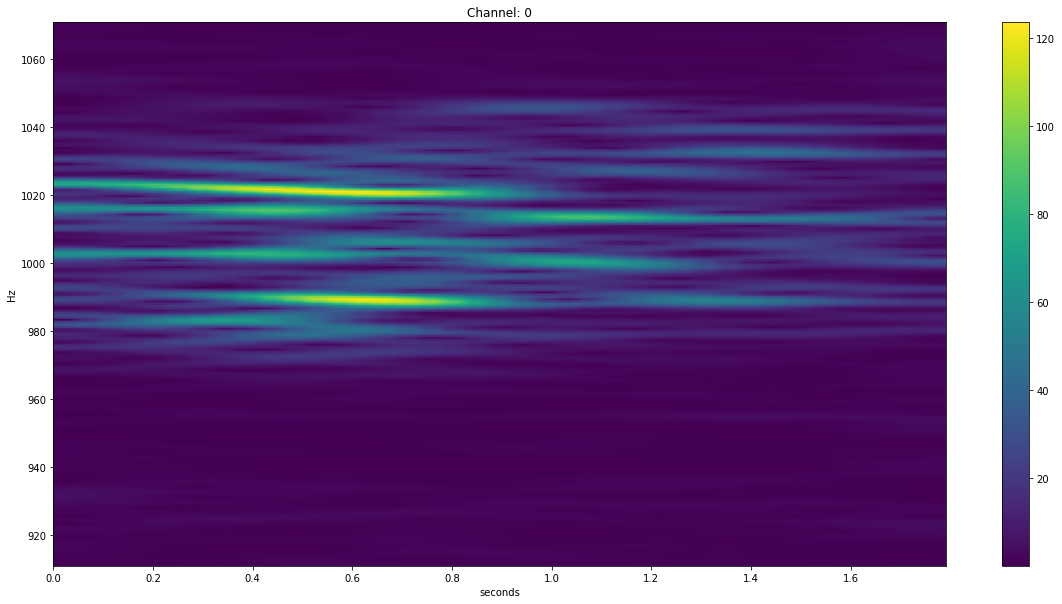

fileName: 1964_52+3.wav
h5
targetFreq:  987.7666025122483
channel 0
error None
sampleRate 44100
targetFreq 987.7666025122483
targetFreqInterval None
acPitchInsensitivity 0.05
watchFrame -1
acWindowLength 4096
acHopLength 256
maxInVoiceJumpInterval None


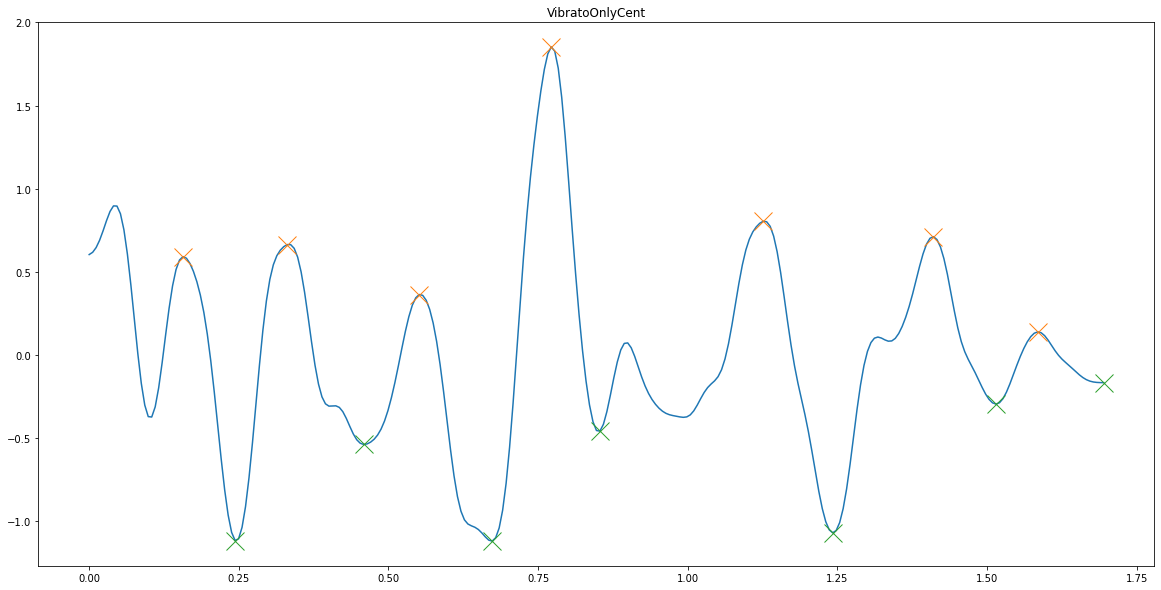

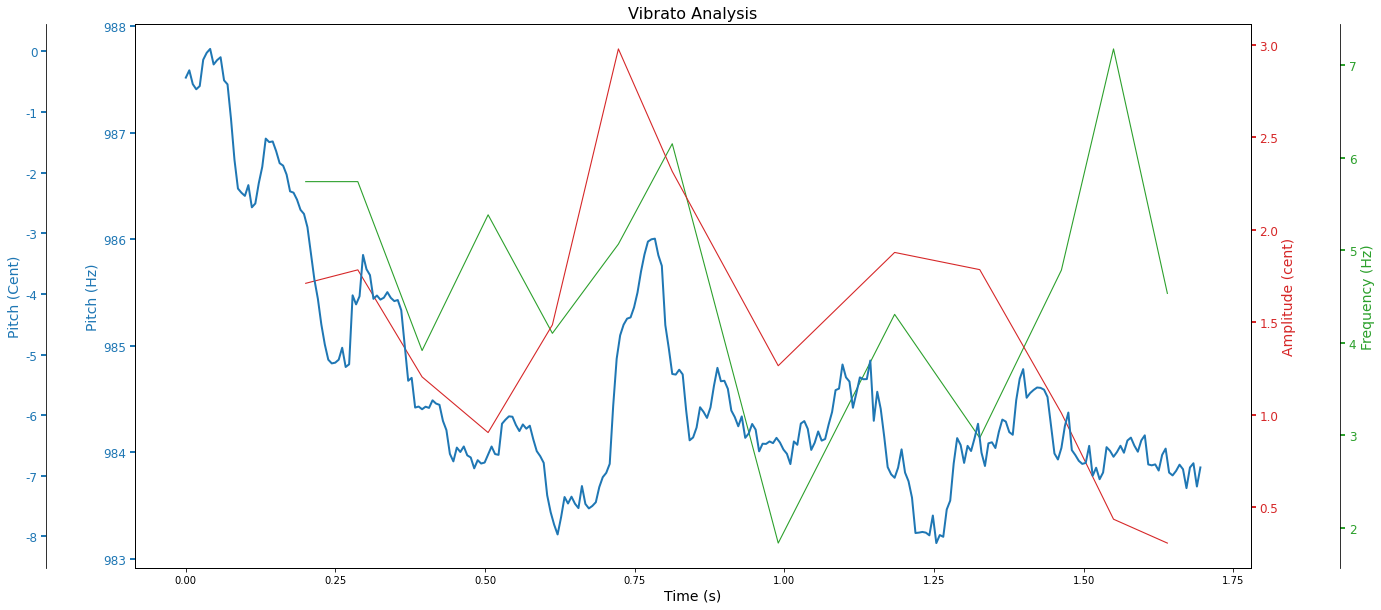

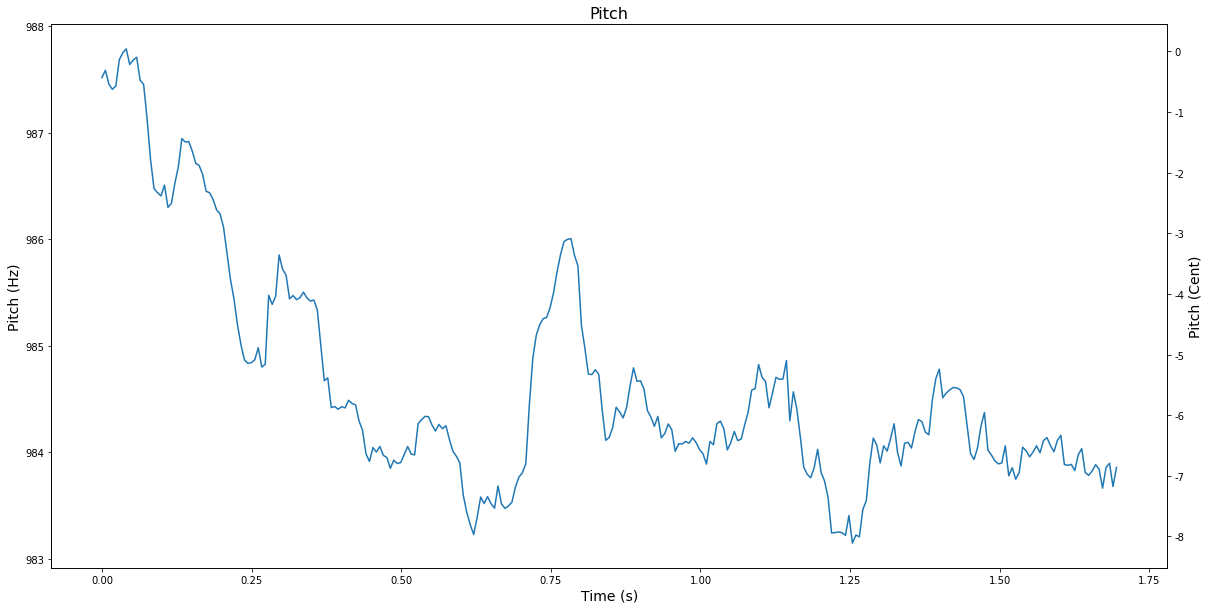

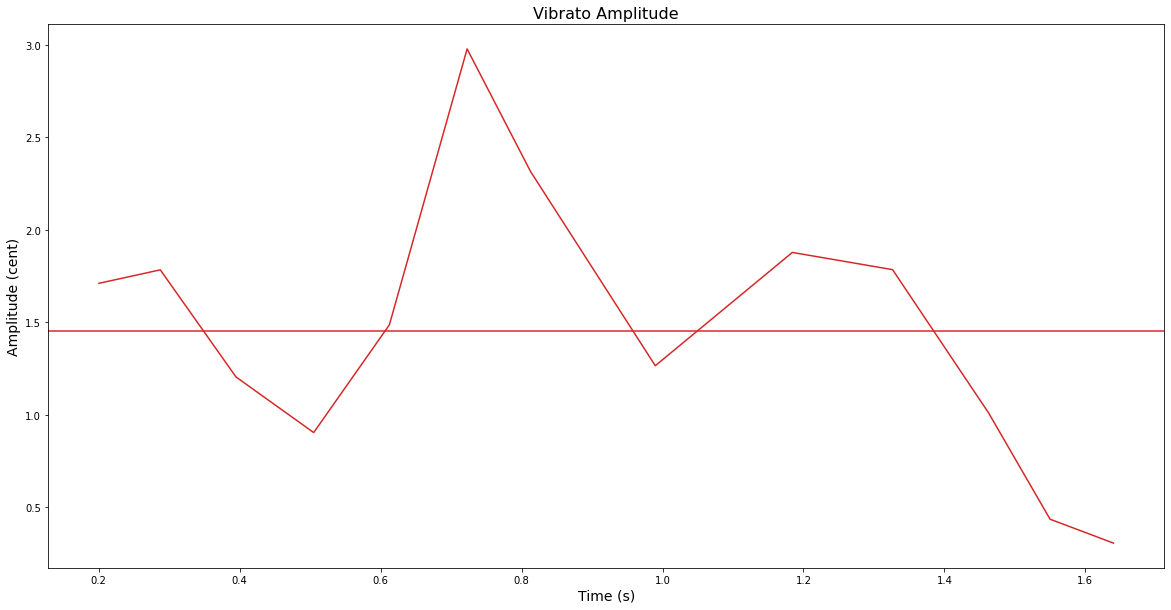

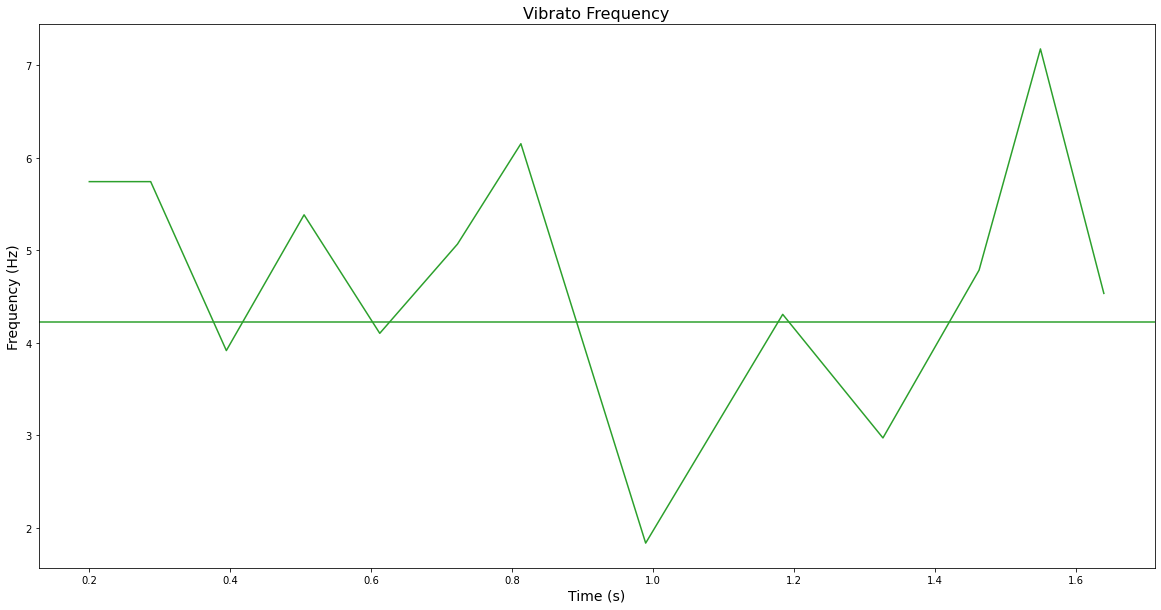

2


In [3]:
noteName=recordingFolder.split(',')[1][1:-1]

targetFreq=noteToFreq(noteName)
targetFreqInterval = 140


channel = chooseChannel(xAudio, targetFreq, targetFreqInterval)
print('fileName:',fileName)
print(noteName)
print('targetFreq: ',targetFreq)
print('channel', channel)

freqs, times, outDict = pitchDetection(xAudio[channel], sr, targetFreq, targetFreqInterval=None)

for k, v in outDict.items():
    print(k,v)

freqsArr = np.array(freqs)
timesArr = np.array(times)


vibAmps, vibFreqs, vibTimes, vibAmpsAvg, vibFreqAvg, extrema, startsWithMinima = VibratoDetection(freqs, times, targetFreq, drawPlots=True)

figs = drawPlots(freqs, times, vibAmps, vibFreqs, vibTimes, vibAmpsAvg, vibFreqAvg, figSize=(20,10))


In [4]:
print(len(figs))
for i in range(0, len(figs[0])):
    print(figs[1][i])
    path='C:\\Users\\ottoh\\Desktop\\test\\'
    os.makedirs(path, exist_ok=True)
    figs[0][i].savefig(path+figs[1][i])
    

2
combi
pitch
vibAmp
vibFreq
